# Part 1: Fully Connected Layers

Daniel-Alexandru Bejan (474404)
Patrick Schaper (534366)

The provided dataset contains possible combinations for the game Yathzee. If you don’t know the rules for this dice game, please have a look at: https://en.wikipedia.org/wiki/Yahtzee.

Please note: the dataset is imbalanced. This means that you might need to balance it first
before you will get good results! There a several possible solutions, please read: https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758 for a better understanding.

You will need to build a neural network that is able to predict the label for 5 thrown dice. The available labels are mentioned in the table below.

- 3-of-a-kind: Three dice the same.
- 4-of-a-kind: Four dice the same.
- Full-house: Three of one number and two of another
- small-straight Four sequential dice: (1-2-3-4, 2-3-4-5, or 3-4-5-6)
- Large-straight Five sequential dice: (1-2-3-4-5 or 2-3-4-5-6)
- Yathzee: All five dice the same
- Nothing: None of the above combinations has been thrown

**Goal of the assignment**

The overall goal is to experiment with deep learning and find out what gives you the
best results. Don’t forget to compare the results and write a conclusion!
Experiments we expect you to carry out:
- Playing around with different networks sizes
 - Different number of layers
 - Different number of neurons per layer
 - At least 6 different networks with a minimum of 1 hidden layer per network
- Comparison of different activation functions:
 - Sigmoid
 - Tanh
 - ReLu
- Difference with and without dropout.

The notebook should contain:
- For each neural network that you train: graphs from TensorBoard or Matplotlib showing the accuracy and the loss for train set and validation set and the accuracy scores for the test set.
- Your observations and conclusions per network (and graph)!
- An export of your best trained network and a way to run this exported model.

**Hints**

In order to build proper neural networks, keep in mind:
- Convert the labels into one-hot-encoded values.
- Use cross-entropy as loss function for classification.
- Create a proper output layer that uses SoftMax activation.
- Use the accuracy metric to measure your classification performance.
- Avoid overfitting by using dropout, a test set (which you use in the end) and cross validation.

Export your best model and add a cell to your notebook that loads the model and is
able to validate your model, by loading in a dataset from file and feeding it into the
network. This cell should show the accuracy of the classifier.


## Analyse the Data

In [1]:
import pandas as pd

df = pd.read_csv('MLBD-dataset-yahtzee.csv')
df.head() 

,dice1,dice2,dice3,dice4,dice5,label
0,3,6,6,2,5,nothing
1,3,6,1,3,4,nothing
2,2,2,5,5,3,nothing
3,1,3,6,6,1,nothing
4,1,4,6,3,5,small-straight


In [2]:
df.shape

(5832, 6)

In [3]:
df.notnull().sum()

dice1    5832
dice2    5832
dice3    5832
dice4    5832
dice5    5832
label    5832
dtype: int64

In [4]:
df.groupby(['label'])['label'].count()

label
four-of-a-kind      116
full-house          221
large-straight      178
nothing            3868
small-straight      549
three-of-a-kind     896
yathzee               4
Name: label, dtype: int64

### First result of analysing

We see a very unbalanced data set. One rubric stands out particularly strongly. The number of "yathzee's" is just 4. According to the rules of the game, a "yathzee" occurs when all dice show the same number. Thus, the minimum number of "yathzee's" is six. Thus, one could normally add the missing records and have a perfect model regarding the yathzee's. This could also be done for the other classes and would create a completely perfect model. But this is probably not our task, so we only mention this here to show that we are aware of it.

For the further process we will not create any datasets manually. We only work with the over and undersampling functions.

Class=0, n=3868 (66.324%)
Class=1, n=549 (9.414%)
Class=2, n=896 (15.364%)
Class=3, n=178 (3.052%)
Class=4, n=221 (3.789%)
Class=5, n=116 (1.989%)
Class=6, n=4 (0.069%)


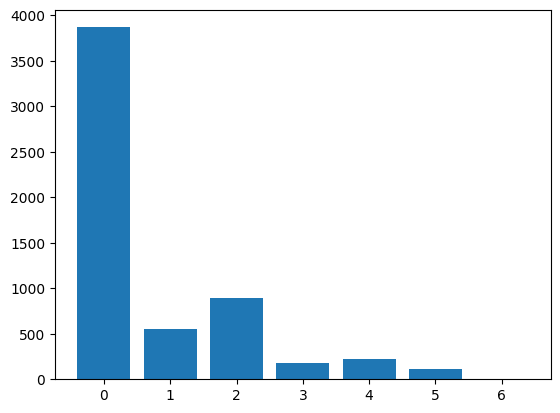

In [5]:
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

df.label = pd.factorize(df.label)[0]

features = []
for feature in df.columns:
    if feature != 'label':
        features.append(feature)
X = df[features]
y = df['label']

y_encoded = LabelEncoder().fit_transform(y)

counter = Counter(y_encoded)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
plt.bar(counter.keys(), counter.values())
plt.show()

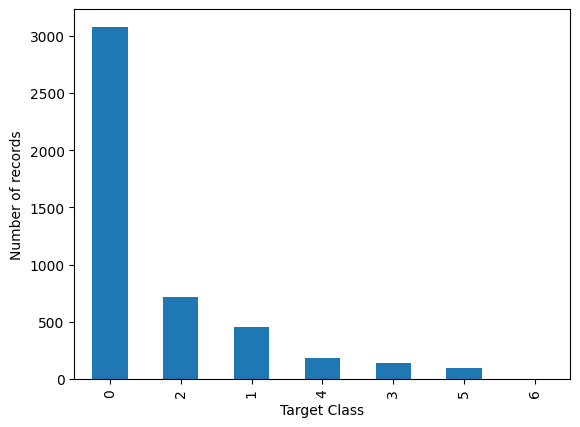

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)#36,39

count = y_train.value_counts()
count.plot.bar()
plt.ylabel('Number of records')
plt.xlabel('Target Class')
plt.show()

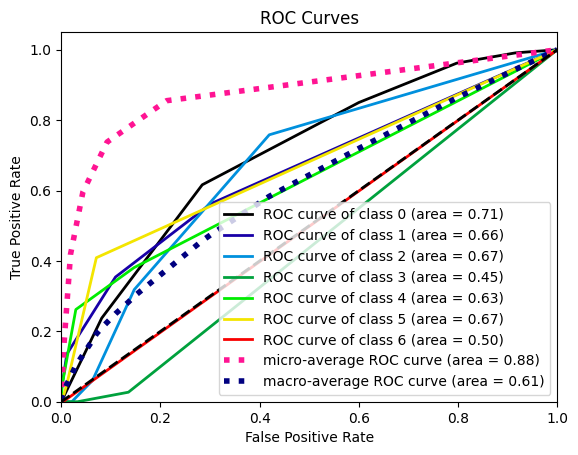

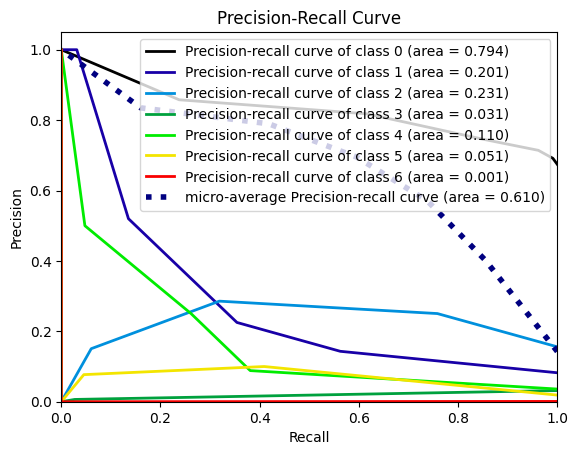

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from sklearn import metrics

model = KNeighborsClassifier()
model.fit(X_train, y_train)

y_score = model.predict_proba(X_test)
y_pred = model.predict(X_test)

# Plot metrics 
plot_roc(y_test, y_score)
plt.show()

plot_precision_recall(y_test, y_score)
plt.show()

In [8]:
from sklearn.neural_network import MLPClassifier

# Varient 1
# 1 input layer with 5 neurons for the dices
# 1 hidden layer with 10 neurons 
# 1 output layer with 6 neurons for the classes
# Activation function is "relu" and optimizer is "adam"

mlp = MLPClassifier(hidden_layer_sizes=(10,), activation="relu", solver="adam", max_iter=350, batch_size=10, verbose=True)

mlp.fit(X_train, y_train)

print("Trainingsresult: %5.3f" % mlp.score(X_train, y_train))


Iteration 1, loss = 1.28183069
Iteration 2, loss = 1.10546627
Iteration 3, loss = 1.08362857
Iteration 4, loss = 1.07729585
Iteration 5, loss = 1.07206355
Iteration 6, loss = 1.06994332
Iteration 7, loss = 1.06569314
Iteration 8, loss = 1.06307389
Iteration 9, loss = 1.06107555
Iteration 10, loss = 1.05766053
Iteration 11, loss = 1.05657344
Iteration 12, loss = 1.05379360
Iteration 13, loss = 1.05168862
Iteration 14, loss = 1.05050214
Iteration 15, loss = 1.04791715
Iteration 16, loss = 1.04614385
Iteration 17, loss = 1.04438824
Iteration 18, loss = 1.04452496
Iteration 19, loss = 1.04112918
Iteration 20, loss = 1.03918044
Iteration 21, loss = 1.03933325
Iteration 22, loss = 1.03627535
Iteration 23, loss = 1.03670782
Iteration 24, loss = 1.03458324
Iteration 25, loss = 1.03337323
Iteration 26, loss = 1.03241919
Iteration 27, loss = 1.03044587
Iteration 28, loss = 1.02969043
Iteration 29, loss = 1.02809051
Iteration 30, loss = 1.02776212
Iteration 31, loss = 1.02823246
Iteration 32, los

In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


def analyse_my_model(model, X_test, y_test):
    predictions = model.predict(X_test)

    print("confusion_matrix:\n", confusion_matrix(y_test, predictions))
    print("\n")
    print("confusion_report:\n", classification_report(y_test, predictions, zero_division=0))
    print("\n")
    print("Trainingsresult: %5.3f" % model.score(X_test, y_test))
    print("\n")
    print("Weights:", model.coefs_[0])
    print("\n")
    print("Biases:", model.intercepts_[0])

    loss_values = model.loss_curve_
    plt.plot(loss_values)
    plt.show()

confusion_matrix:
 [[774   0  13   0   0   0   0]
 [ 96   0   0   0   0   0   0]
 [166   0  16   0   0   0   0]
 [ 37   0   0   0   0   0   0]
 [ 27   0  15   0   0   0   0]
 [ 13   0   8   0   0   1   0]
 [  0   0   0   0   0   1   0]]


confusion_report:
               precision    recall  f1-score   support

           0       0.70      0.98      0.81       787
           1       0.00      0.00      0.00        96
           2       0.31      0.09      0.14       182
           3       0.00      0.00      0.00        37
           4       0.00      0.00      0.00        42
           5       0.50      0.05      0.08        22
           6       0.00      0.00      0.00         1

    accuracy                           0.68      1167
   macro avg       0.21      0.16      0.15      1167
weighted avg       0.53      0.68      0.57      1167



Trainingsresult: 0.678


Weights: [[-3.79341656e-02 -1.74607029e-03  1.18649104e-02 -3.70308491e-02
  -4.56717303e-01 -2.47101578e-02  9.154942

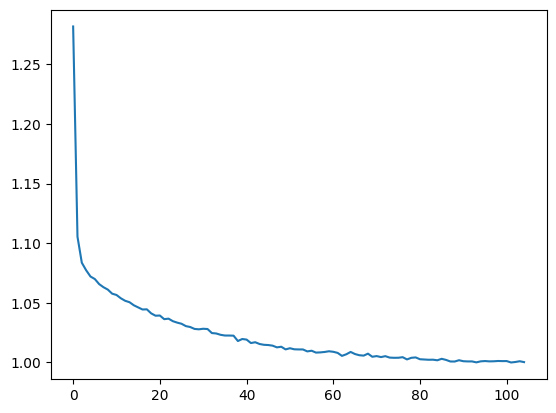

In [10]:
analyse_my_model(mlp, X_test, y_test)

In [11]:
# Varient 2
# 1 input layer with 5 neurons for the dices
# 1 hidden layer with 5 neurons
# 1 hidden layer with 3 neurons
# 1 output layer with 6 neurons for the classes
# Activation function is "tanh" and optimizer is "adam"

mlp = MLPClassifier(hidden_layer_sizes=(5,3), activation="tanh", solver="adam", max_iter=350, batch_size=10, verbose=True)

mlp.fit(X_train, y_train)

print("Trainingsresult: %5.3f" % mlp.score(X_train, y_train))

Iteration 1, loss = 1.58814254
Iteration 2, loss = 1.15754140
Iteration 3, loss = 1.11815197
Iteration 4, loss = 1.10833489
Iteration 5, loss = 1.10522814
Iteration 6, loss = 1.10318386
Iteration 7, loss = 1.10206644
Iteration 8, loss = 1.10045603
Iteration 9, loss = 1.09923570
Iteration 10, loss = 1.09817718
Iteration 11, loss = 1.09673651
Iteration 12, loss = 1.09576363
Iteration 13, loss = 1.09436714
Iteration 14, loss = 1.09306058
Iteration 15, loss = 1.09162641
Iteration 16, loss = 1.08978830
Iteration 17, loss = 1.08743922
Iteration 18, loss = 1.08511747
Iteration 19, loss = 1.08192145
Iteration 20, loss = 1.07869377
Iteration 21, loss = 1.07539818
Iteration 22, loss = 1.07254440
Iteration 23, loss = 1.07079994
Iteration 24, loss = 1.06795548
Iteration 25, loss = 1.06687374
Iteration 26, loss = 1.06549015
Iteration 27, loss = 1.06467066
Iteration 28, loss = 1.06352168
Iteration 29, loss = 1.06225052
Iteration 30, loss = 1.06113488
Iteration 31, loss = 1.06029534
Iteration 32, los

confusion_matrix:
 [[760   0  27   0   0   0   0]
 [ 94   0   2   0   0   0   0]
 [154   0  27   0   1   0   0]
 [ 37   0   0   0   0   0   0]
 [ 25   0  13   0   2   2   0]
 [  8   0  13   0   0   1   0]
 [  0   0   1   0   0   0   0]]


confusion_report:
               precision    recall  f1-score   support

           0       0.71      0.97      0.82       787
           1       0.00      0.00      0.00        96
           2       0.33      0.15      0.20       182
           3       0.00      0.00      0.00        37
           4       0.67      0.05      0.09        42
           5       0.33      0.05      0.08        22
           6       0.00      0.00      0.00         1

    accuracy                           0.68      1167
   macro avg       0.29      0.17      0.17      1167
weighted avg       0.56      0.68      0.59      1167



Trainingsresult: 0.677


Weights: [[-0.43982974 -0.14228541  0.75132759  0.49009498 -0.47877073]
 [-0.43244656 -0.12658896 -0.38302881 -0.94872

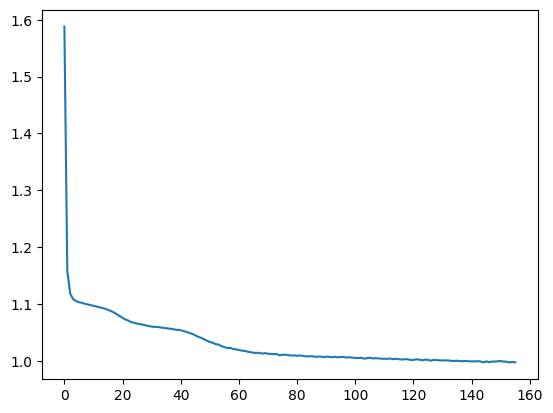

In [12]:
analyse_my_model(mlp, X_test, y_test)

In [13]:
n_samples = int(round(count.median()))

print(n_samples)

179


In [14]:
def sampling_strategy(X, y, n_samples, t='majority'):
    target_classes = ''
    if t == 'majority':
        target_classes = y.value_counts() > n_samples
    elif t == 'minority':
        target_classes = y.value_counts() < n_samples
    tc = target_classes[target_classes == True].index
    #target_classes_all = y.value_counts().index
    sampling_strategy = {}
    for target in tc:
        sampling_strategy[target] = n_samples
    return sampling_strategy

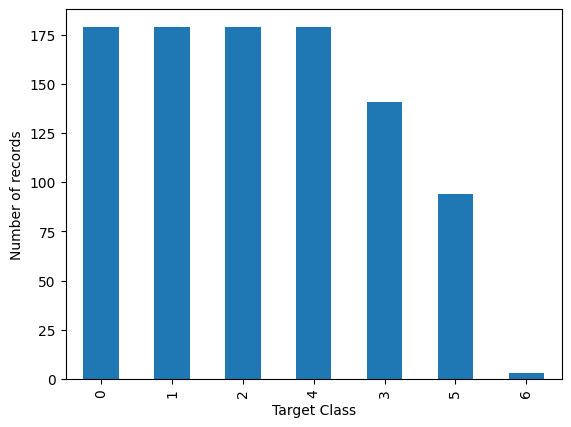

In [15]:
from imblearn.under_sampling import ClusterCentroids

under_sampler = ClusterCentroids(sampling_strategy=sampling_strategy(X_train, y_train, n_samples, t='majority'))

X_under, y_under = under_sampler.fit_resample(X_train, y_train)

count = y_under.value_counts()
count.plot.bar()
plt.ylabel('Number of records')
plt.xlabel('Target Class')
plt.show()

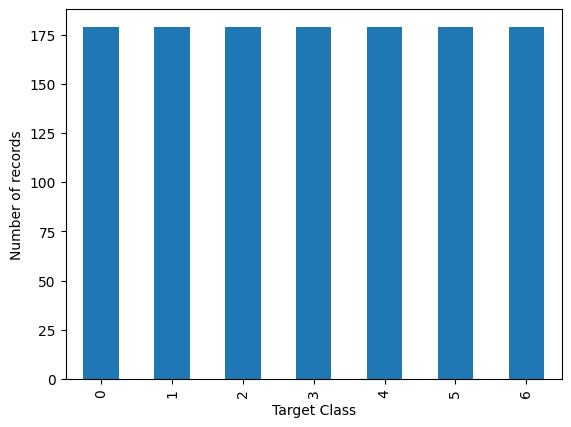

In [16]:
from imblearn.over_sampling import SMOTE

over_sampler = SMOTE(sampling_strategy=sampling_strategy(X_under, y_under, n_samples, t='minority'), k_neighbors=2)

X_bal, y_bal = over_sampler.fit_resample(X_under, y_under)

count = y_bal.value_counts()
count.plot.bar()
plt.ylabel('Number of records')
plt.xlabel('Target Class')
plt.show()

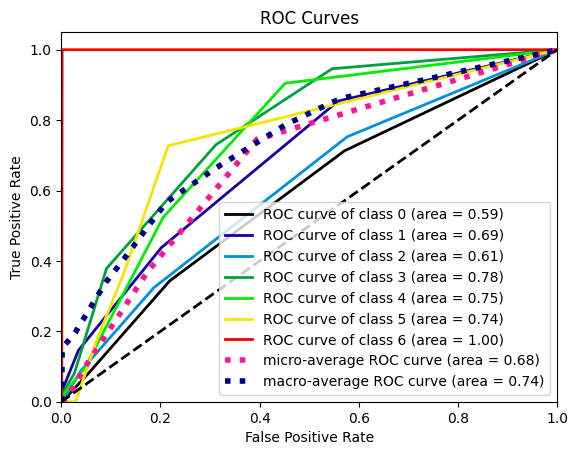

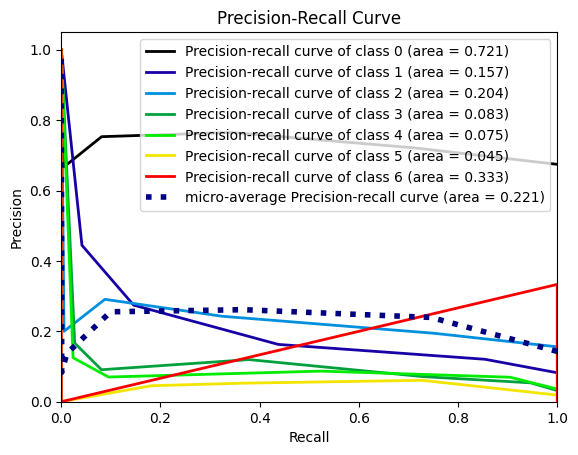

In [17]:
model = KNeighborsClassifier()
model.fit(X_bal, y_bal)

y_score = model.predict_proba(X_test)
y_pred = model.predict(X_test)

# Plot metrics 
plot_roc(y_test, y_score)
plt.show()

plot_precision_recall(y_test, y_score)
plt.show()

In [18]:
#Variant 1
mlp = MLPClassifier(hidden_layer_sizes=(10,), activation="relu", solver="adam", max_iter=350, batch_size=10, verbose=True)

mlp.fit(X_bal, y_bal)

print("Trainingsresult: %5.3f" % mlp.score(X_train, y_train))

Iteration 1, loss = 2.66072106
Iteration 2, loss = 2.09509348
Iteration 3, loss = 1.97930949
Iteration 4, loss = 1.94494442
Iteration 5, loss = 1.90697120
Iteration 6, loss = 1.87761679
Iteration 7, loss = 1.85610364
Iteration 8, loss = 1.83341848
Iteration 9, loss = 1.81420609
Iteration 10, loss = 1.79419693
Iteration 11, loss = 1.77549672
Iteration 12, loss = 1.76100407
Iteration 13, loss = 1.74898543
Iteration 14, loss = 1.73507880
Iteration 15, loss = 1.72359775
Iteration 16, loss = 1.71253092
Iteration 17, loss = 1.70137878
Iteration 18, loss = 1.69034703
Iteration 19, loss = 1.68201524
Iteration 20, loss = 1.67082877
Iteration 21, loss = 1.66293817
Iteration 22, loss = 1.65081509
Iteration 23, loss = 1.64457517
Iteration 24, loss = 1.63448465
Iteration 25, loss = 1.62355795
Iteration 26, loss = 1.61500767
Iteration 27, loss = 1.60814166
Iteration 28, loss = 1.59936311
Iteration 29, loss = 1.59206709
Iteration 30, loss = 1.58605858
Iteration 31, loss = 1.57629098
Iteration 32, los

confusion_matrix:
 [[186  34  24 385 116  42   0]
 [  8   4  13  34  23  14   0]
 [ 19   9  20  55  37  42   0]
 [  2   0   0  30   5   0   0]
 [  4   0   5  11   5  17   0]
 [  3   1   1   2   5   9   1]
 [  0   0   0   0   0   0   1]]


confusion_report:
               precision    recall  f1-score   support

           0       0.84      0.24      0.37       787
           1       0.08      0.04      0.06        96
           2       0.32      0.11      0.16       182
           3       0.06      0.81      0.11        37
           4       0.03      0.12      0.04        42
           5       0.07      0.41      0.12        22
           6       0.50      1.00      0.67         1

    accuracy                           0.22      1167
   macro avg       0.27      0.39      0.22      1167
weighted avg       0.63      0.22      0.29      1167



Trainingsresult: 0.219


Weights: [[ 3.16054767e-01  1.00974374e-02 -1.15974938e+00  1.81344541e-01
  -1.32279995e-01  1.11373416e-02 -4.423047

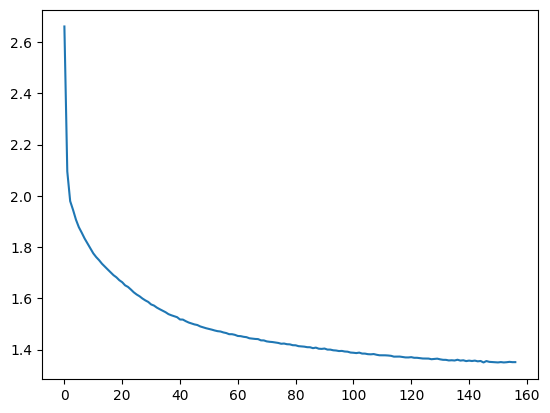

In [19]:
analyse_my_model(mlp, X_test, y_test)

In [20]:
#Variant 2
mlp = MLPClassifier(hidden_layer_sizes=(5,3), activation="tanh", solver="adam", max_iter=350, batch_size=10, verbose=True)

mlp.fit(X_train, y_train)

print("Trainingsresult: %5.3f" % mlp.score(X_train, y_train))

Iteration 1, loss = 1.53932596
Iteration 2, loss = 1.17200562
Iteration 3, loss = 1.13269571
Iteration 4, loss = 1.11968580
Iteration 5, loss = 1.11337885
Iteration 6, loss = 1.10949447
Iteration 7, loss = 1.10719039
Iteration 8, loss = 1.10523927
Iteration 9, loss = 1.10337668
Iteration 10, loss = 1.10182543
Iteration 11, loss = 1.10049682
Iteration 12, loss = 1.09846945
Iteration 13, loss = 1.09697026
Iteration 14, loss = 1.09575029
Iteration 15, loss = 1.09438215
Iteration 16, loss = 1.09296834
Iteration 17, loss = 1.09137207
Iteration 18, loss = 1.09128538
Iteration 19, loss = 1.09043081
Iteration 20, loss = 1.08898414
Iteration 21, loss = 1.08758917
Iteration 22, loss = 1.08640140
Iteration 23, loss = 1.08451319
Iteration 24, loss = 1.08324232
Iteration 25, loss = 1.08157878
Iteration 26, loss = 1.08000830
Iteration 27, loss = 1.07891056
Iteration 28, loss = 1.07761530
Iteration 29, loss = 1.07710985
Iteration 30, loss = 1.07583666
Iteration 31, loss = 1.07447780
Iteration 32, los

confusion_matrix:
 [[746   0  41   0   0   0   0]
 [ 83   0  13   0   0   0   0]
 [138   0  41   0   0   3   0]
 [ 37   0   0   0   0   0   0]
 [ 27   0  12   0   0   3   0]
 [ 12   0   9   0   0   1   0]
 [  1   0   0   0   0   0   0]]


confusion_report:
               precision    recall  f1-score   support

           0       0.71      0.95      0.81       787
           1       0.00      0.00      0.00        96
           2       0.35      0.23      0.28       182
           3       0.00      0.00      0.00        37
           4       0.00      0.00      0.00        42
           5       0.14      0.05      0.07        22
           6       0.00      0.00      0.00         1

    accuracy                           0.68      1167
   macro avg       0.17      0.17      0.17      1167
weighted avg       0.54      0.68      0.59      1167



Trainingsresult: 0.675


Weights: [[-0.67042693  0.16827162  0.01287842 -0.13582716 -1.57613272]
 [ 0.37255503  0.13448441  0.70882083 -0.22034

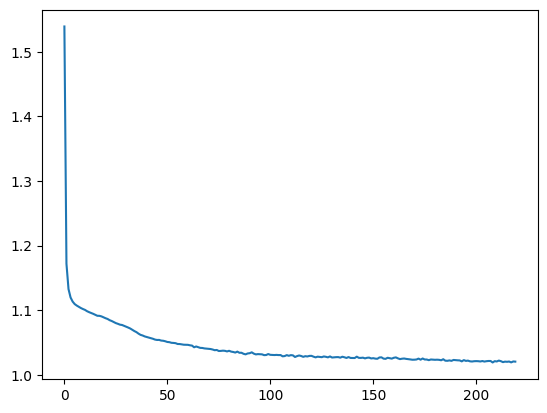

In [21]:
analyse_my_model(mlp, X_test, y_test)